# Interest-rate sensitivities via zero spread

As usual we import the whole module and define a few utilities.

In [1]:
from QuantLib import *
today = Date(8, March, 2016)
Settings.instance().evaluationDate = today

In [13]:
import matplotlib.pyplot as plt
import numpy as np
pylab.rcParams['figure.figsize'] = [9, 6]
from matplotlib.ticker import FuncFormatter
def plot_curves(*curves):
    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter(FuncFormatter(lambda r,pos: '%.2g%%' % (r*100)))
    ax.set_xlim(0,15)
    ax.set_xticks([0,5,10,15])
    times = np.linspace(0.0, 15.0, 400)
    for curve, style in curves:
        rates = [ curve.zeroRate(t, Continuous).rate() for t in times ]
        plt.plot(times, rates, style)
def plot_curve(curve):
    plot_curves((curve, '-'))

#### Setup

Let's say we have an interest rate cuve, no matter how it was calculated...

In [4]:
quotes = [ SimpleQuote(0.312/100) ]
helpers = [ DepositRateHelper(QuoteHandle(quotes[0]),
                             Period(6, Months), 3,
                             TARGET(), Following, False, Actual360()) ]

for rate, months_to_start in [(0.293, 1), (0.272, 2), (0.260, 3),
                             (0.256, 4), (0.252, 5), (0.248, 6),
                             (0.254, 7), (0.261, 8), (0.267, 9),
                             (0.279, 10), (0.291, 11), (0.303, 12),
                             (0.318, 13), (0.335, 14), (0.352, 15),
                             (0.371, 16), (0.389, 17), (0.409, 18)]:
    quotes.append(SimpleQuote(rate/100))
    helpers.append(FraRateHelper(QuoteHandle(quotes[-1]),
                                months_to_start, Euribor6M()))
    
for rate, tenor in [(0.424, 3), (0.576, 4), (0.762, 5),
                             (0.954, 6), (1.135, 7), (1.303, 8),
                             (1.452, 9), (1.584, 10), (1.809, 12),
                             (2.037, 15), (2.187, 20), (2.234, 25),
                             (2.256, 30), (2.295, 35), (2.348, 40),
                             (2.421, 50), (2.463, 60)]:
    quotes.append(SimpleQuote(rate/100))
    helpers.append(SwapRateHelper(QuoteHandle(quotes[-1]),
                                Period(tenor, Years), TARGET(),
                                  Annual, Unadjusted, Thirty360(Thirty360.BondBasis),
                                  Euribor6M())) 

rate_curve = PiecewiseLogCubicDiscount(2, TARGET(), helpers, Actual365Fixed())
curve_handle = RelinkableYieldTermStructureHandle(rate_curve)

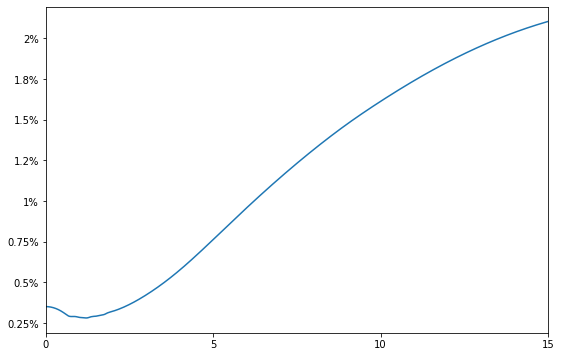

In [14]:
plot_curve(rate_curve)

...and we're using it to price an interest rate swap.

In [17]:
fixed_schedule = Schedule(Date(8, April, 2016), Date(8, April, 2028),
                         Period(1, Years), TARGET(), Following, Following,
                         DateGeneration.Forward, False)
floating_schedule = Schedule(Date(8, April, 2016), Date(8, April, 2028),
                            Period(6, Months), TARGET(), Following, Following,
                            DateGeneration.Forward, False)
index = Euribor6M(curve_handle)
swap = VanillaSwap(VanillaSwap.Payer, 10000.0,
                  fixed_schedule, 0.02, Thirty360(),
                   floating_schedule, index, 0.0, Actual360())

In [18]:
swap.setPricingEngine(DiscountingSwapEngine(curve_handle))
P0 = swap.NPV()
print(P0)

-189.83267948709386


Now let's say that you're interest in how the swap price reacts to changes in the underlying rates.

#### Interest rate sensitivities

If you're interested in the sensitivities of the price of the input rates, you can have them: shift the input rates and relcalculate the NPV.

In [19]:
bp = 1.0e-4
ref = quotes[0].value()
quotes[0].setValue(ref+1*bp)
print(swap.NPV())
quotes[0].setValue(ref)

-190.10699701198928
